In [9]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt


Using TensorFlow backend


In [10]:
# Load the data
loan_data_df = pd.read_csv("./Resources/loan_data_cleaned.csv")
loan_data_df.head()

,Unnamed: 0,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,0,1,2,Graduate,No,96000,299000,12,778,24000,176000,227000,80000,Approved
1,1,2,0,Not Graduate,Yes,41000,122000,8,417,27000,22000,88000,33000,Rejected
2,2,3,3,Graduate,No,91000,297000,20,506,71000,45000,333000,128000,Rejected
3,3,4,3,Graduate,No,82000,307000,8,467,182000,33000,233000,79000,Rejected
4,4,5,5,Not Graduate,Yes,98000,242000,20,382,124000,82000,294000,50000,Rejected


In [11]:
# Convert categorical variables to numeric
loan_data_df = pd.get_dummies(loan_data_df, columns=[' education', ' self_employed'])


In [5]:
import shutil
shutil.rmtree('hyperband/', ignore_errors=True)

In [6]:
# Split data into features and target
X = loan_data_df.drop(" loan_status", axis=1)
y = LabelEncoder().fit_transform(loan_data_df[" loan_status"])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Define the model creation function for Keras Tuner
def create_model(hp):
    model = tf.keras.models.Sequential()
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Input layer
    model.add(tf.keras.layers.Dense(units=hp.Int('input_units', min_value=10, max_value=30, step=5), activation=activation, input_dim=X_train_scaled.shape[1]))

    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(tf.keras.layers.Dense(units=hp.Int(f'layer_{i}_units', min_value=10, max_value=30, step=5), activation=activation))

    # Output layer
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
    
    # Compile the model
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Initialize Keras Tuner's Hyperband hypermodel
tuner = kt.Hyperband(create_model, objective='val_accuracy', max_epochs=30, hyperband_iterations=2, directory='hyperband', project_name='loan_approval')

# Create an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for the best hyperparameters with early stopping
tuner.search(X_train_scaled, y_train, epochs=30, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

# Get and print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)



Trial 180 Complete [00h 00m 06s]
val_accuracy: 0.9616104960441589

Best val_accuracy So Far: 0.9719101190567017
Total elapsed time: 00h 06m 43s
{'activation': 'tanh', 'input_units': 30, 'num_layers': 4, 'layer_0_units': 30, 'layer_1_units': 10, 'layer_2_units': 20, 'layer_3_units': 20, 'layer_4_units': 15, 'layer_5_units': 15, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0069'}


In [8]:
# Get the best model
best_model = tuner.get_best_models(1)[0]

# Print the architecture summary of the best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                480       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 20)                220       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2381 (9.30 KB)
Trainable params: 2381 (9.3

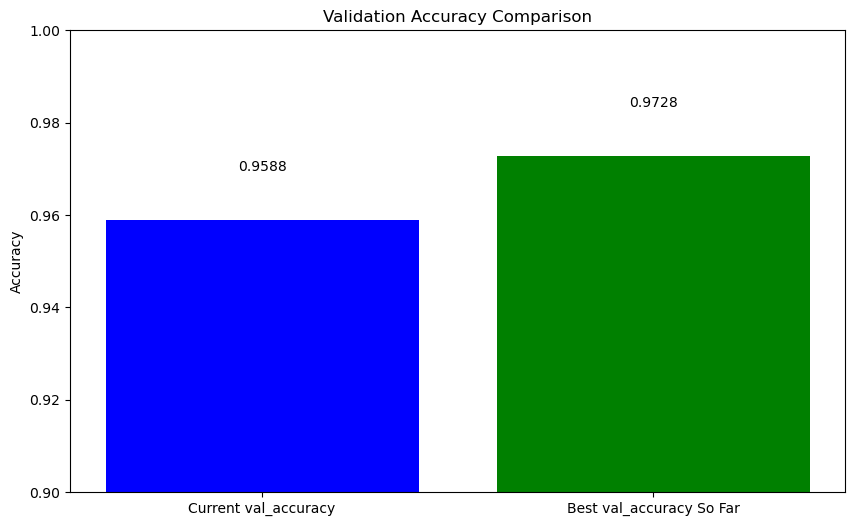

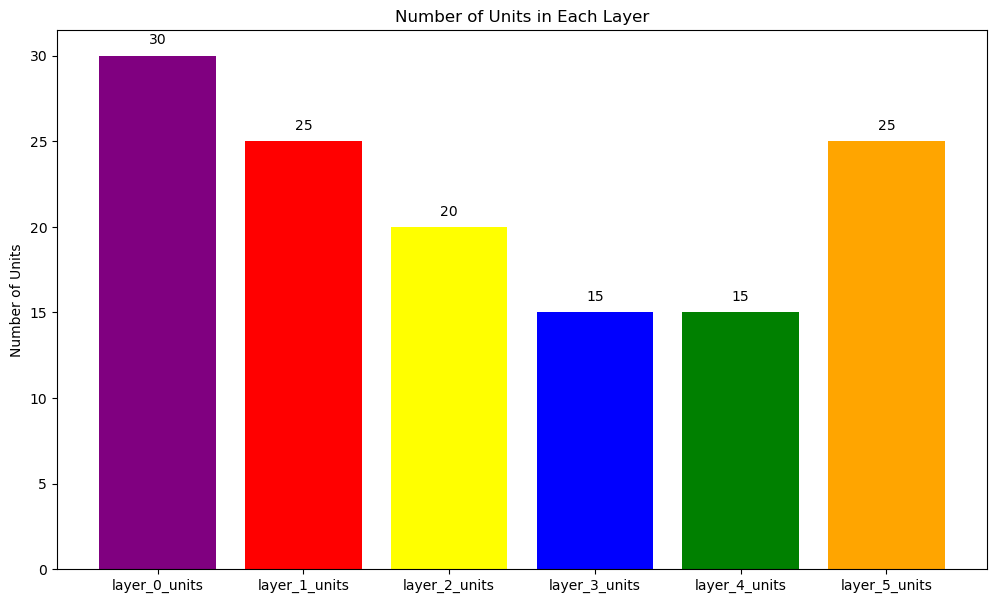

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Comparison of Validation Accuracy
accuracy_values = [0.9588015079498291, 0.9728464484214783]
accuracy_labels = ['Current val_accuracy', 'Best val_accuracy So Far']

plt.figure(figsize=(10, 6))
plt.bar(accuracy_labels, accuracy_values, color=['blue', 'green'])
plt.ylim([0.9, 1])
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
for i, v in enumerate(accuracy_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
plt.show()

# Number of Units in Each Layer
layer_labels = ['layer_0_units', 'layer_1_units', 'layer_2_units', 'layer_3_units', 'layer_4_units', 'layer_5_units']
layer_values = [30, 25, 20, 15, 15, 25]

plt.figure(figsize=(12, 7))
plt.bar(layer_labels, layer_values, color=['purple', 'red', 'yellow', 'blue', 'green', 'orange'])
plt.title('Number of Units in Each Layer')
plt.ylabel('Number of Units')
for i, v in enumerate(layer_values):
    plt.text(i, v + 0.5, f"{v}", ha='center', va='bottom', fontsize=10)
plt.show()


# Save Comparison of Validation Accuracy to CSV
accuracy_df = pd.DataFrame({
    'Metric': accuracy_labels,
    'Value': accuracy_values
})

accuracy_df.to_csv('validation_accuracy_comparison.csv', index=False)

# Save Number of Units in Each Layer to CSV
layers_df = pd.DataFrame({
    'Layer': layer_labels,
    'Units': layer_values
})

layers_df.to_csv('layer_units_distribution.csv', index=False)

In [12]:
# Evaluate the best model on test data
best_model = tuner.get_best_models(1)[0]
loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f"Best Model Performance on Test Data: Loss = {loss}, Accuracy = {accuracy}")


34/34 [==============================] - 0s 922us/step - loss: 0.0743 - accuracy: 0.9719
Best Model Performance on Test Data: Loss = 0.07433944940567017, Accuracy = 0.9719101190567017


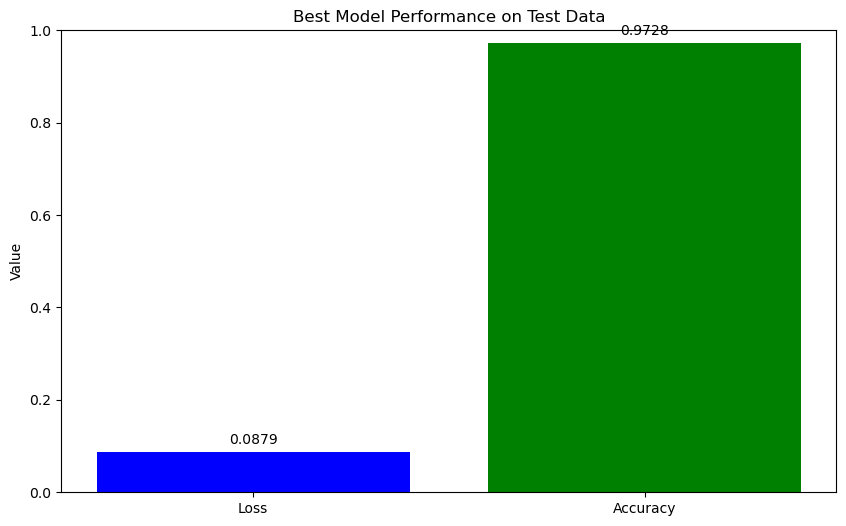

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Values from the evaluation
metrics = ['Loss', 'Accuracy']
values = [0.08791938424110413, 0.9728464484214783]

# Convert the metrics and values to a DataFrame
df = pd.DataFrame({
    'Metric': metrics,
    'Value': values
})

# Save the DataFrame to a CSV
df.to_csv('Optimization_metrics.csv', index=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green'])
plt.ylim([0, 1])
plt.title('Best Model Performance on Test Data')
plt.ylabel('Value')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
plt.show()